# Dashboard XSell

In [1]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
import datetime 
    #pyplot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
#from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from analystcommunity.read_connection_data_warehouse import run_read_dwd_query

In [2]:
start_of_month = datetime.datetime.today().replace(day=1).strftime("%Y-%m-%d")
today = datetime.datetime.today().strftime("%Y-%m-%d")

In [3]:
query = """
SELECT 
    CASE WHEN s.identifier_value IN ('BAQ','BOG','MDE','SPO','BHZ','CWB','VCP','CMX') THEN 'LATAM' END AS region_code,
    fs.order_close_date AS close_date,
    fs.order_id,
    dc.source_id AS customer_id,
    cat.parent_description as category,
    cat.description AS subcat,
    dp.card_id AS padre_sku_id,
    dp.source_id AS sku_id,
    fs.product_quantity_x_step_unit AS cant,
    fs.gmv_pxq AS gmv_usd
    
FROM dpr_sales.fact_sales                   fs
INNER JOIN dpr_shared.dim_customer          dc  ON dc.customer_id = fs.dim_customer
INNER JOIN dpr_shared.dim_site              s   ON s.site_id = fs.dim_site
INNER JOIN dpr_shared.dim_product           dp  ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_category          cat ON cat.category_id = dp.category_id

WHERE 
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
    AND fs.fb_order_status_id  IN (1,6,7,8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND dim_business_segment = 57
    AND DATE(fs.order_close_date) between '{Fecha_start}' AND '{Fecha_end}'
    AND cat.parent_description <> 'Frubana prime'
""".format(Fecha_start="2024-01-01",Fecha_end="2024-01-31") # cambiar mes !!!

data_ventas = run_read_dwd_query(query)
data_ventas['close_date'] = pd.to_datetime(data_ventas['close_date'])
data_ventas[["cant",'gmv_usd']] = data_ventas[["cant",'gmv_usd']].astype(float)

In [4]:
data_ventas["month"] = data_ventas["close_date"].dt.month
total_buyers = data_ventas["customer_id"].nunique()

#// Data Cleaning
AllItems = data_ventas.copy()

In [5]:
data_ventas.category = data_ventas.category.replace('Despensa', 'Abarrotes')
data_ventas = data_ventas.loc[data_ventas.category != 'Mesa & cocina']	

In [6]:
data_ventas.describe()

,order_id,customer_id,padre_sku_id,sku_id,cant,gmv_usd,month
count,1.621500e+06,1.621500e+06,1.621500e+06,1.621500e+06,1.621500e+06,1.621500e+06,1621500.0
mean,2.999918e+07,1.762325e+08,1.550286e+05,2.417716e+05,8.859998e+00,1.456689e+01,1.0
std,4.382563e+05,1.288401e+08,2.364463e+05,3.261063e+05,2.601051e+01,3.758083e+01,0.0
min,2.859498e+07,-2.699190e+05,-2.030390e+05,-3.150220e+05,0.000000e+00,0.000000e+00,1.0
25%,2.961811e+07,5.347690e+07,1.080000e+04,7.249700e+04,2.000000e+00,2.701260e+00,1.0
50%,2.996727e+07,1.573242e+08,2.030200e+05,2.963890e+05,3.000000e+00,5.882950e+00,1.0
75%,3.036567e+07,3.173832e+08,3.509660e+05,5.561540e+05,1.000000e+01,1.451789e+01,1.0
max,3.130581e+07,3.685914e+08,4.708720e+05,6.505840e+05,1.500000e+04,1.172667e+04,1.0


In [7]:
print("En este periodo de tiempo, Frubana ha atendido {:,} restaurantes".format(total_buyers))

En este periodo de tiempo, Frubana ha atendido 60,415 restaurantes


In [8]:
def penetration(df):
    return df["customer_id"].nunique()

def aov(df):
    return df.groupby(by=["order_id"])["gmv_usd"].sum().mean()

def frequency(df):
    return df.groupby(by=["customer_id"])["order_id"].nunique().mean()

def arpu(df):
    return df.groupby(by=["customer_id"])["gmv_usd"].sum().mean()
    
def tabla1(df, total_users):
    columnas = {}
    def penetration(df):
        return df["customer_id"].nunique()

    def aov(df):
        return df.groupby(by=["order_id"])["gmv_usd"].sum().mean()
    
    def frequency(df):
        return df.groupby(by=["customer_id"])["order_id"].nunique().mean()
    
    def arpu(df):
        return df.groupby(by=["customer_id"])["gmv_usd"].sum().mean()
    
    columnas["penetration"] = penetration(df)
    columnas["penetration"] = columnas["penetration"]/total_users
    
    columnas["aov"] = aov(df)
    
    columnas["frequency"] = frequency(df)
    
    columnas["arpu"] = arpu(df)
    
    return pd.Series(columnas, index=list(columnas.keys()))

In [9]:
def metricas_xsell(df, total_users):
    resumen_general = tabla1(df=df, total_users=total_users)
    assert ((resumen_general["aov"]*resumen_general["frequency"])/resumen_general["arpu"] - 1 < 0.00001).all()
    assert ((resumen_general["arpu"]*total_buyers*resumen_general["penetration"]).sum()/data_ventas["gmv_usd"].sum() - 1 < 0.00001).all()
    resumen_general = resumen_general.reset_index()
    resumen_general.columns = ["KPI", "General"]
    resumen_general.set_index(keys=["KPI"], inplace=True)
    resumen_general = resumen_general.drop(index=["penetration"])
    return resumen_general

In [10]:
resumen_general = metricas_xsell(df=data_ventas, total_users = total_buyers)
resumen_general.T.style.format({"aov":"${:.2f}", "frequency":"{:.2f}", "arpu":"${:.2f}"})

KPI,aov,frequency,arpu
General,$95.36,4.10,$390.97


## Category Deep Dive

In [11]:
df_tabla1 = data_ventas.groupby(by=["category"]).apply(tabla1, total_users=total_buyers)
df_tabla1 = df_tabla1.sort_values(by=["penetration"], ascending=False)

assert ((df_tabla1["aov"]*df_tabla1["frequency"])/df_tabla1["arpu"] - 1 < 0.00001).all()
assert ((df_tabla1["arpu"]*total_buyers*df_tabla1["penetration"]).sum()/data_ventas["gmv_usd"].sum() - 1 < 0.00001).all()

df_tabla1.sort_index().head(10).style.format({"penetration":"{:.2%}", "aov":"${:.2f}", "frequency":"{:.2f}", "arpu":"${:.2f}"})

,penetration,aov,frequency,arpu
category,,,,
Abarrotes,34.85%,$62.72,3.27,$205.01
Abarrotes & despensa,12.28%,$58.81,2.75,$161.56
Aseo e higiene,30.59%,$7.55,2.08,$15.74
Bebidas,45.58%,$38.74,2.44,$94.43
"Carne, pollo & pescados",13.60%,$31.83,2.66,$84.74
"Carnes, aves e peixes",15.24%,$45.56,2.55,$116.38
Congelados,16.83%,$25.10,2.29,$57.46
Descartáveis,8.37%,$9.59,1.65,$15.81
Desechables,30.30%,$12.98,2.25,$29.23


In [12]:
df_tabla13 = data_ventas.groupby(by=["category"]).apply(tabla1, total_users=total_buyers)

In [13]:
df_tabla13.head(10)

,penetration,aov,frequency,arpu
category,,,,
Abarrotes,0.348457,62.722998,3.268573,205.014701
Abarrotes & despensa,0.122817,58.812203,2.747035,161.559184
Aseo e higiene,0.305851,7.553775,2.083938,15.741596
Bebidas,0.455831,38.739647,2.437598,94.431670
"Carne, pollo & pescados",0.136009,31.834563,2.661920,84.741073
"Carnes, aves e peixes",0.152412,45.555904,2.554626,116.378317
Congelados,0.168286,25.102397,2.289171,57.463676
Descartáveis,0.083704,9.587354,1.649199,15.811455
Desechables,0.302971,12.975865,2.253005,29.234686


## # Category / Subcat per Customer

In [14]:
def distribution(df, feature):
    return df.groupby(by=["customer_id"])[feature].nunique()

def tabla2(df, feature_filter):
    distribution_series = distribution(df=df, feature=feature_filter)
    assert distribution_series.index.nunique() == df["customer_id"].nunique()
    if feature_filter == "category":
        custom_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8 ]
        custom_labels = ["1", "2", "3", "4","5","6","7","8"]
    elif feature_filter == "subcat":
        custom_bins = [0, 3, 6, 9, np.inf]
        custom_labels = ["1-3", "4-6", "7-9", "10 o más"]
    
    number_features_by_customer = pd.cut(x=distribution_series, bins=custom_bins, labels=custom_labels)
    #assert not number_features_by_customer.isna().any()
    result = number_features_by_customer.value_counts(normalize=True)
    return result

# Category
print("-------------------")
df_tabla2_category = tabla2(df=data_ventas, feature_filter="category")
number_category_by_customer = distribution(df=data_ventas, feature="category").to_dict()
data_ventas["number_of_category"] = data_ventas["customer_id"].map(number_category_by_customer)
df_tabla2_category = df_tabla2_category.reset_index()
df_tabla2_category.columns = ["number_of_category", "percentage_of_clients"]
display(df_tabla2_category.sort_values(by=["number_of_category"]).style.format({"percentage_of_clients":"{:.2%}"}))

# Subcat
print("-------------------")
df_tabla2_subcat = tabla2(df=data_ventas, feature_filter="subcat")
number_subcat_by_customer = distribution(df=data_ventas, feature="subcat").to_dict()
data_ventas["number_of_subcat"] = data_ventas["customer_id"].map(number_subcat_by_customer)
df_tabla2_subcat = df_tabla2_subcat.reset_index()
df_tabla2_subcat.columns = ["number_of_subcat", "percentage_of_clients"]
display(df_tabla2_subcat.sort_values(by=["number_of_subcat"]).style.format({"percentage_of_clients":"{:.2%}"}))

-------------------


,number_of_category,percentage_of_clients
4,1,14.07%
2,2,16.77%
0,3,18.03%
1,4,17.81%
3,5,14.81%
5,6,10.13%
6,7,5.80%
7,8,2.58%


-------------------


,number_of_subcat,percentage_of_clients
1,1-3,26.16%
2,4-6,25.25%
3,7-9,17.66%
0,10 o más,30.93%


In [15]:
def distribution(df, feature):
    return df.groupby(by=["customer_id"])[feature].nunique()

def tabla2(df, feature_filter):
    distribution_series = distribution(df=df, feature=feature_filter)
    assert distribution_series.index.nunique() == df["customer_id"].nunique()
    if feature_filter == "category":
        custom_bins = [0, 1, 2, 3, 4, np.inf]
        custom_labels = ["1", "2", "3", "4", "5 o más"]
    elif feature_filter == "subcat":
        custom_bins = [0, 3, 6, 9, np.inf]
        custom_labels = ["1-3", "4-6", "7-9", "10 o más"]
    
    number_features_by_customer = pd.cut(x=distribution_series, bins=custom_bins, labels=custom_labels)
    assert not number_features_by_customer.isna().any()
    result = number_features_by_customer.value_counts(normalize=True)
    return result

# Category
print("-------------------")
df_tabla2_category = tabla2(df=data_ventas, feature_filter="category")
number_category_by_customer = distribution(df=data_ventas, feature="category").to_dict()
data_ventas["number_of_category"] = data_ventas["customer_id"].map(number_category_by_customer)
df_tabla2_category = df_tabla2_category.reset_index()
df_tabla2_category.columns = ["number_of_category", "percentage_of_clients"]
display(df_tabla2_category.sort_values(by=["number_of_category"]).style.format({"percentage_of_clients":"{:.2%}"}))

# Subcat
print("-------------------")
df_tabla2_subcat = tabla2(df=data_ventas, feature_filter="subcat")
number_subcat_by_customer = distribution(df=data_ventas, feature="subcat").to_dict()
data_ventas["number_of_subcat"] = data_ventas["customer_id"].map(number_subcat_by_customer)
df_tabla2_subcat = df_tabla2_subcat.reset_index()
df_tabla2_subcat.columns = ["number_of_subcat", "percentage_of_clients"]
display(df_tabla2_subcat.sort_values(by=["number_of_subcat"]).style.format({"percentage_of_clients":"{:.2%}"}))

-------------------


,number_of_category,percentage_of_clients
4,1,14.07%
3,2,16.77%
1,3,18.03%
2,4,17.81%
0,5 o más,33.32%


-------------------


,number_of_subcat,percentage_of_clients
1,1-3,26.16%
2,4-6,25.25%
3,7-9,17.66%
0,10 o más,30.93%


# Category / Subcategory Journey

In [16]:
def double_click_table2(df, feature_filtrado):
    total_uids = df["customer_id"].nunique()
    result = df.groupby(by=[feature_filtrado])["customer_id"].nunique()/total_uids
    if feature_filtrado == "category":
        assert result.sum()/df["number_of_category"].unique()[0] - 1 < 0.0001
    elif feature_filtrado == "subcat":
        assert result.sum()/df["number_of_subcat"].unique()[0] - 1 < 0.0001
    return result

data_ventas## Category Penetration / Subcat Penetration by # Category / Subcat Bought

In [17]:
# double_click_table2_df = data_ventas.groupby(by=["number_of_subcat"]).apply(double_click_table2, feature_filtrado="subcat") # Subcat
double_click_table2_df = data_ventas.groupby(by=["number_of_category"]).apply(double_click_table2, feature_filtrado="category") # Category
if type(double_click_table2_df) == pd.core.series.Series:
    double_click_table2_df = double_click_table2_df.unstack().fillna(0)

double_click_table2_df = double_click_table2_df.T
double_click_table2_df = double_click_table2_df.sort_values(by=[1], ascending=False)
# double_click_table2_df.style.format("{:.2%}") # Subcat
#double_click_table2_df.sort_index().style.format("{:.2%}") # Category

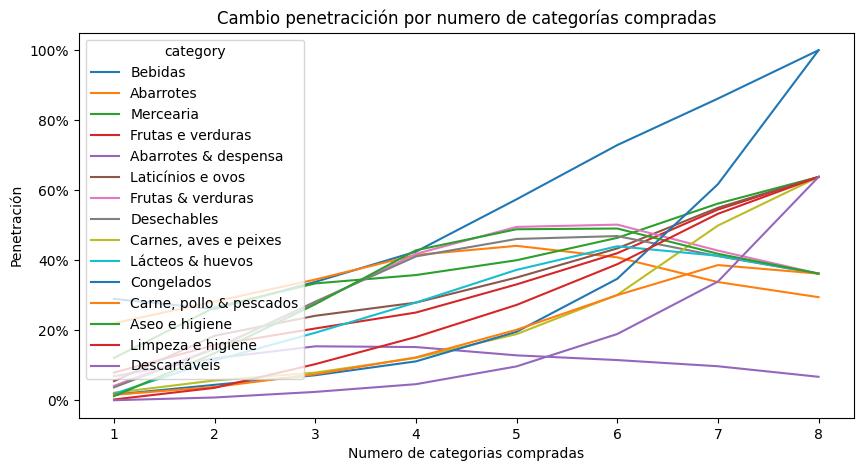

In [18]:
ax = double_click_table2_df.T.plot.line(figsize=(10,5))
plt.title("Cambio penetracición por numero de categorías compradas")
plt.xlabel("Numero de categorias compradas")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.ylabel("Penetración")
plt.show()
plt.close()

In [19]:
double_click_table2_df = data_ventas.groupby(by=["number_of_subcat"]).apply(double_click_table2, feature_filtrado="subcat") # Subcat
if type(double_click_table2_df) == pd.core.series.Series:
    double_click_table2_df = double_click_table2_df.unstack().fillna(0)


double_click_table2_df = double_click_table2_df.T
double_click_table2_df = double_click_table2_df.sort_values(by=[1], ascending=False)
# double_click_table2_df.style.format("{:.2%}") # Subcat
#double_click_table2_df.sort_index().style.format("{:.2%}") # Category

# Category / Subcategory Journey - Net users

In [20]:
def double_click_table2(df, feature_filtrado):
    total_uids = df["customer_id"].nunique()
    result = df.groupby(by=[feature_filtrado])["customer_id"].nunique()
    #if feature_filtrado == "category":
        #assert result.sum()/df["number_of_category"].unique()[0] - 1 < 0.0001
    #elif feature_filtrado == "subcat":
        #assert result.sum()/df["number_of_subcat"].unique()[0] - 1 < 0.0001
    return result

In [21]:
# double_click_table2_df = data_ventas.groupby(by=["number_of_subcat"]).apply(double_click_table2, feature_filtrado="subcat") # Subcat
double_click_table2_df = data_ventas.groupby(by=["number_of_category"]).apply(double_click_table2, feature_filtrado="category") # Category
if type(double_click_table2_df) == pd.core.series.Series:
    double_click_table2_df = double_click_table2_df.unstack().fillna(0)


double_click_table2_df = double_click_table2_df.T
double_click_table2_df = double_click_table2_df.sort_values(by=[1], ascending=False)
# double_click_table2_df.style.format("{:.2%}") # Subcat
#double_click_table2_df.sort_index()#.style.format("{:.2%}") # Category

In [22]:
double_click_table2_df = data_ventas.groupby(by=["number_of_subcat"]).apply(double_click_table2, feature_filtrado="subcat") # Subcat
if type(double_click_table2_df) == pd.core.series.Series:
    double_click_table2_df = double_click_table2_df.unstack().fillna(0)

double_click_table2_df = double_click_table2_df.T
double_click_table2_df = double_click_table2_df.sort_values(by=[1], ascending=False)
# double_click_table2_df.style.format("{:.2%}") # Subcat
#double_click_table2_df.sort_index()#.style.format("{:.2%}") # Category

In [23]:
# users_birthday_date = users_birthday(ciudad=city_code)
# data_ventas["birthdate"] = data_ventas["customer_id"].map(users_birthday_date)
# data_ventas["days_of_life"] = (data_ventas["close_date"] - data_ventas["birthdate"]).dt.days
# data_ventas["months_of_life"] = (data_ventas["close_date"] - data_ventas["birthdate"]).dt.days/30

In [24]:
#df_lifetime = data_ventas.groupby(by=["number_of_category"])["months_of_life"].mean().reset_index()

## Deep Dive per # Category

In [25]:
df_lifetime = data_ventas.groupby(by=["number_of_category"]).agg({"gmv_usd":np.sum, "customer_id":pd.Series.nunique, "order_id":pd.Series.nunique}).reset_index()
df_lifetime["ARPU"] =  df_lifetime["gmv_usd"]/df_lifetime["customer_id"]
df_lifetime["AoV"] = df_lifetime["gmv_usd"]/df_lifetime["order_id"]
df_lifetime["frecuency"] = df_lifetime["order_id"]/df_lifetime["customer_id"]
assert ((df_lifetime["frecuency"] * df_lifetime["AoV"])/df_lifetime["ARPU"]-1 < 0.000001).all()
assert (df_lifetime["ARPU"]*df_lifetime["customer_id"]).sum()/data_ventas["gmv_usd"].sum() - 1 < 0.0000001
df_lifetime.drop(labels=["gmv_usd", "customer_id", "order_id"], axis=1, inplace=True)
df_lifetime.sort_values(by=["number_of_category"]).style.format({"ARPU":"${:.2f}", "AoV":"${:.2f}", "frecuency":"{:.2f}"})

,number_of_category,ARPU,AoV,frecuency
0,1,$166.35,$81.68,2.04
1,2,$218.88,$84.74,2.58
2,3,$279.54,$85.88,3.25
3,4,$364.82,$90.50,4.03
4,5,$467.79,$94.60,4.94
5,6,$640.24,$102.26,6.26
6,7,$870.11,$112.78,7.72
7,8,$1196.13,$118.20,10.12


In [26]:
data_ventas["number_of_subcat"] = np.where(data_ventas["number_of_subcat"].between(1, 3), "1-3", np.where(data_ventas["number_of_subcat"].between(4, 6), "4-6", np.where(data_ventas["number_of_subcat"].between(7, 9), "7-9", "10 o más")))

In [27]:
df_lifetime = data_ventas.groupby(by=["number_of_subcat"]).agg({"gmv_usd":np.sum, "customer_id":pd.Series.nunique, "order_id":pd.Series.nunique}).reset_index()
df_lifetime["ARPU"] =  df_lifetime["gmv_usd"]/df_lifetime["customer_id"]
df_lifetime["AoV"] = df_lifetime["gmv_usd"]/df_lifetime["order_id"]
df_lifetime["frecuency"] = df_lifetime["order_id"]/df_lifetime["customer_id"]
assert ((df_lifetime["frecuency"] * df_lifetime["AoV"])/df_lifetime["ARPU"]-1 < 0.000001).all()
assert (df_lifetime["ARPU"]*df_lifetime["customer_id"]).sum()/data_ventas["gmv_usd"].sum() - 1 < 0.0000001
df_lifetime.drop(labels=["gmv_usd", "customer_id", "order_id"], axis=1, inplace=True)
df_lifetime.sort_values(by=["number_of_subcat"]).style.format({"ARPU":"${:.2f}", "AoV":"${:.2f}", "frecuency":"{:.2f}"})

,number_of_subcat,ARPU,AoV,frecuency
0,1-3,$155.32,$76.49,2.03
1,10 o más,$738.26,$109.00,6.77
2,4-6,$242.72,$80.23,3.03
3,7-9,$343.57,$85.49,4.02
